In [1]:
import pandas as pd
import requests
import numpy as np

from datetime import datetime
from dateutil import parser
from matplotlib import pyplot as plt

from urllib import parse
from data_pull import data_pull_date
from data_pull import data_pull_all

In [2]:
# Energy Generation Type (All)
# "f93d1835-75bc-43e5-84ad-12472b180a98"
# https://data.nationalgrideso.com/carbon-intensity1/historic-generation-mix/r/historic_gb_generation_mix

# Energy Demand (2019)
# dd9de980-d724-415a-b344-d8ae11321432
# https://data.nationalgrideso.com/demand/historic-demand-data/r/historic_demand_data_2019

# Energy Cost (2019-2020 Financial Year)
# 6a03c415-475f-4005-bf55-b9108291c511
# https://data.nationalgrideso.com/trade-data/historic-gtma-grid-trade-master-agreement-trades-data/r/historic_gtma_trades_data_-_apr_2019_-_march_2020

# System Frequency (Dec 2019)
# f0933bdd-1b0e-4dd3-aa7f-5498df1ba5b9    
# https://data.nationalgrideso.com/system/system-frequency-data/r/december_2019_-_historic_frequency_data

### Load Generation Data

In [3]:

datacode3 = "6a03c415-475f-4005-bf55-b9108291c511"
entry_limit = '1000'

cst = data_pull_all(datacode3,entry_limit)
cst['Start Time'] = pd.to_datetime(cst['Start Time'], format="%Y/%m/%d %H:%M:%S")
cst['End Time'] = pd.to_datetime(cst['End Time'], format="%Y/%m/%d %H:%M:%S")

start_time = cst.loc[0,"Start Time"]
start_str = "Start Time: {}".format(start_time)
print(start_str)

idx = cst.index[-1]
end_time = cst.loc[idx,"Start Time"]
end_str = "End Time: {}".format(end_time)
print(end_str) 

cst.dtypes

Start Time: 2019-04-01 00:00:00+00:00
End Time: 2019-04-26 04:00:00+00:00


_count                     object
Price                      object
_full_text                 object
Start Time    datetime64[ns, UTC]
SO Flag                    object
Volume                     object
End Time      datetime64[ns, UTC]
Cost                       object
Trade ID                   object
_id                         int64
dtype: object

### Convert to floats, remove negative cost and non-system transactions

In [4]:
cst['Cost'] = cst['Cost'].astype(float)
cst['Price'] = cst['Price'].astype(float)
cst['Volume'] = cst['Volume'].astype(float)

cst = cst[cst['Cost']<0]
print(len(cst))

811


### Calculate  Average Prices

#### Calculate Hourly Energy Volumes

In [5]:
starts = cst['Start Time']
ends = cst['End Time']
vols = -cst['Volume']

time_diffs = ends - starts
time_diffs = time_diffs / pd.to_timedelta(1, unit='H')

ave_vols = vols/time_diffs
cst['Average Volume'] = ave_vols

#### Calculate weighted average prices

In [6]:
dtm_interp = pd.date_range(start_time, end_time, freq="30min")
# print(dtm_interp)

prices = []

for ii in dtm_interp:  
    mask = (starts <= ii) &\
       (ends > ii)
    
    foo = cst.loc[mask, 'Price'] * ave_vols[mask] 
    foo = foo/sum(ave_vols[mask])
    prices.append( foo.mean() )

In [7]:
print(len(prices))
print(len(dtm_interp))
# print(prices)

1209
1209


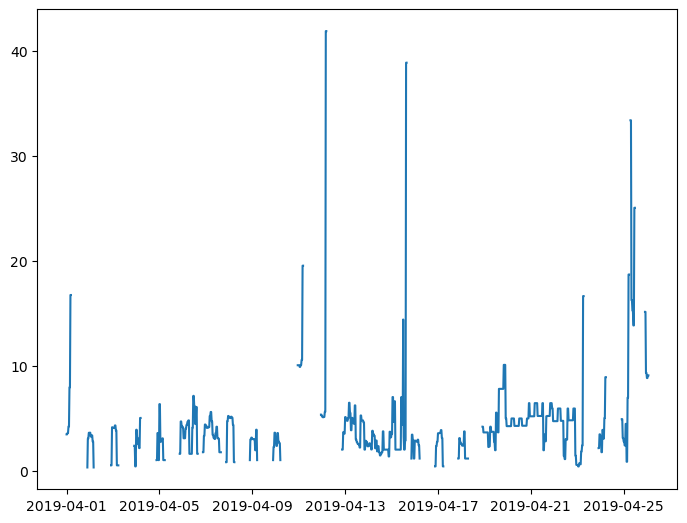

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dtm_interp,prices)

# plt.xlim([17985, 18000])